# Optimizing Factor Portfolios with Hierarchical Clustering

Our objective is to analyze the weight dynamics throughout the allocation process. While performance enhancement is desirable, implementing optimized allocations in real-world environments can pose challenges. Let's assess the feasibility of our weight dynamics for practical application.

## Load libraries

In [1]:
import os
import sys

os.chdir("../..")

cwd = os.getcwd()

for root, dirs, file in os.walk(cwd):
    sys.path.append(root)

In [2]:
cwd

'c:\\Users\\HP\\Desktop\\Work\\Projects\\factor_investing'

In [3]:
import polars as pl
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from tqdm import tqdm

In [4]:
from utils import set_layout

In [5]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## Load Data

#### Ptf infos

In [6]:
PATH_TO_DATA_FACTOR_INFOS = "data/raw_data/factor_cluster_label.csv"

df_ptf_infos = (
    pl.read_csv(PATH_TO_DATA_FACTOR_INFOS).with_columns(
        pl.col("date").str.to_date(format="%Y-%m-%d"),
        pl.col("available_date").str.to_date(format="%Y-%m-%d"),
    )
    # .rename({"portfolio": "name", "factor": "cluster"})
)

#### Ptf returns

In [7]:
PATH_TO_DATA_FACTOR_RETURNS = "data/raw_data/us_factors_vw_daily.csv"

df_ptf_rets = (
    pl.read_csv(PATH_TO_DATA_FACTOR_RETURNS)
    .with_columns(
        pl.col("date").str.to_date(format="%Y-%m-%d"),
    )
    .join(
        df_ptf_infos.select(["available_date", "portfolio", "factor"]), on="portfolio", how="left"
    )
)

#### Allocation data

In [8]:
PATH_TO_DATA_ALLOCATION = "data/prep_data/alloc/bounded"
ALLOCATION_METHOD = "average"

FILENAMES = (
    pl.DataFrame({"filename": os.listdir(PATH_TO_DATA_ALLOCATION)})
    .filter(pl.col("filename").str.contains(ALLOCATION_METHOD))
    .to_series()
    .sort()
    .to_list()
)

out = []
for filename in FILENAMES:
    out.append(
        pl.read_parquet(os.path.join(PATH_TO_DATA_ALLOCATION, filename))
        .select(["name", "date", "relative_weight", "cluster"])
        .with_columns(pl.lit(filename).alias("alloc_model"))
    )

df_alloc = pl.concat(out)

In [9]:
ALLOC_MODELS_NAMES = df_alloc.select("alloc_model").to_series().unique().sort().to_list()

In [10]:
df_glob_alloc = df_alloc_temp = (
    df_alloc.filter(pl.col("alloc_model") == ALLOC_MODELS_NAMES[0])
    .drop("alloc_model")
    .rename({"relative_weight": f"rw_{ALLOC_MODELS_NAMES[0]}"})
)

for model in tqdm(ALLOC_MODELS_NAMES[1:]):
    df_glob_alloc = df_glob_alloc.join(
        df_alloc.filter(pl.col("alloc_model") == model)
        .drop("alloc_model")
        .rename({"relative_weight": f"rw_{model}"}),
        on=["date", "name", "cluster"],
        how="left",
    )

df_glob_alloc = df_glob_alloc.with_columns(
    pl.sum_horizontal(pl.col("^rw.*$")).truediv(len(ALLOC_MODELS_NAMES)).alias("rw_glob_model")
).select(["date", "name", "cluster", "rw_glob_model"])

100%|██████████| 17/17 [00:00<00:00, 56.26it/s]


## Global Allocation through factors

In [11]:
df_glob_weight_per_factor = (
    df_glob_alloc.group_by(["date", "cluster"])
    .agg(pl.col("rw_glob_model").sum())
    .sort(["date", "cluster"])
)

#### Weight allocate to each factor through T

In [12]:
df_glob_weight_per_factor.plot(
    x="date", y="rw_glob_model", by="cluster", height=350, title="Weight allocate to each factor"
)

:NdOverlay   [cluster]
   :Curve   [date]   (rw_glob_model)

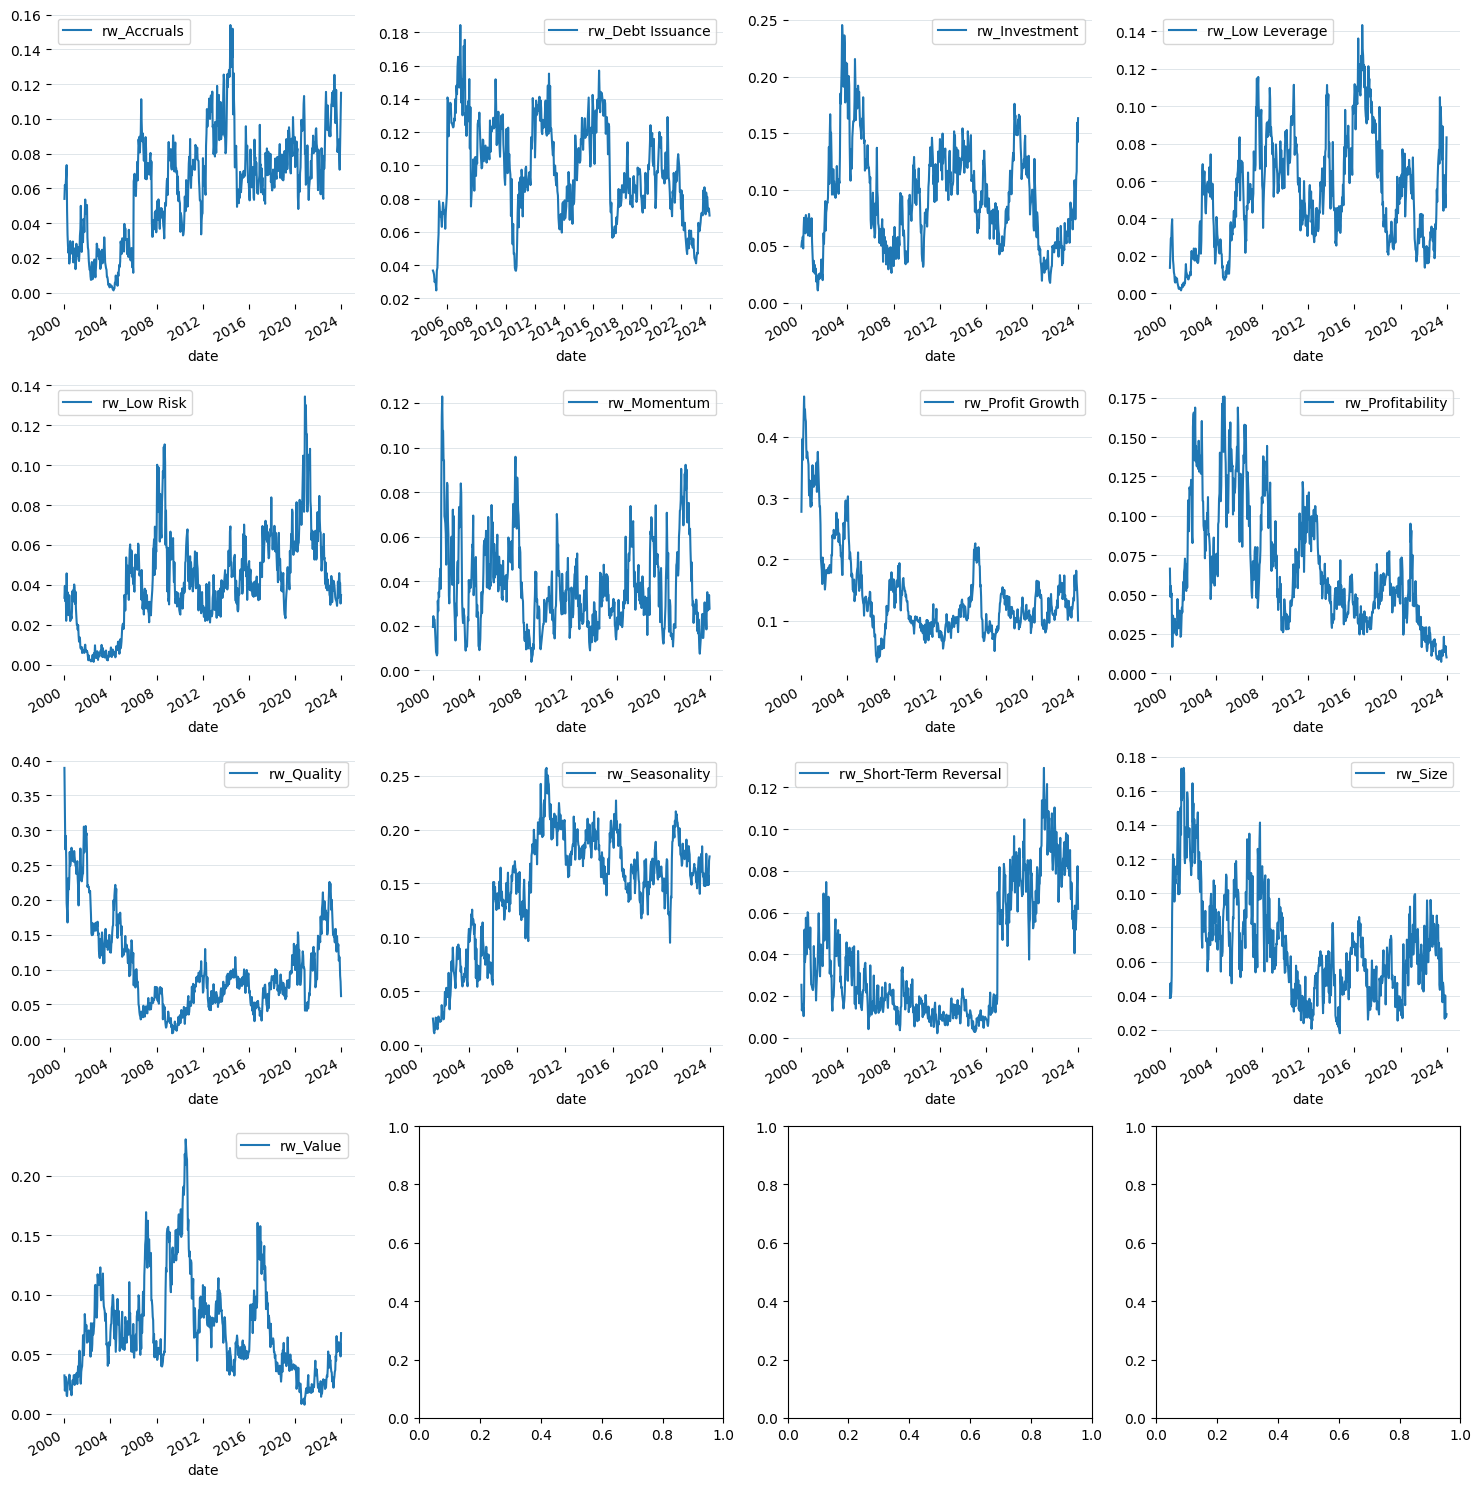

In [13]:
FACTORS = df_glob_weight_per_factor.select("cluster").to_series().unique().sort().to_list()

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15, 15))
idx = [(i, j) for i in range(4) for j in range(4)]

for i, factor in enumerate(FACTORS):
    (
        df_glob_weight_per_factor.filter(pl.col("cluster") == factor)
        .select(["date", "rw_glob_model"])
        .rename({"rw_glob_model": f"rw_{factor}"})
        .to_pandas()
        .set_index("date")
        .plot(ax=ax[idx[i]])
    )
    set_layout(ax[idx[i]])
plt.tight_layout()

We have visualized the weights assigned to each global factor throughout the allocation process by our global model. As observed, there is no significant concentration of weights on any particular factor (except for profit growth during 2000-2004). This is encouraging, as our goal is to maintain diversified weight allocation across all factors, ensuring a dynamic portfolio.

#### Max weight allocate to one factor

In [17]:
df_glob_weight_per_factor.group_by(["date"]).agg(pl.col("rw_glob_model").max().alias("max_weight"))

date,max_weight
date,f64
2000-01-10,0.389453
2000-01-24,0.341824
2000-02-07,0.396478
2000-02-22,0.362289
2000-03-06,0.398187
…,…
2023-10-30,0.181471
2023-11-13,0.161624
2023-11-27,0.159069


<Axes: title={'center': 'Maximum weight allocation to one factor'}, xlabel='returns'>

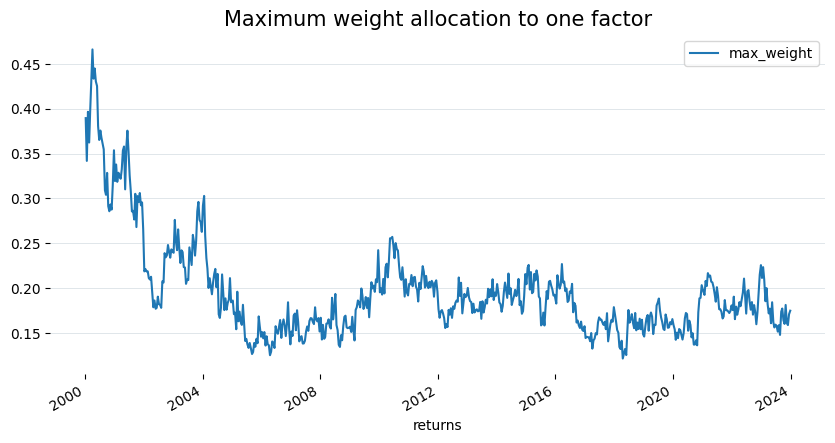

In [21]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

df_glob_weight_per_factor.group_by(["date"]).agg(
    pl.col("rw_glob_model").max().alias("max_weight")
).to_pandas().set_index("date").plot(ax=ax)
ax.set_title("Maximum weight allocation to one factor", size=15)
ax.set_xlabel("returns")
set_layout(ax=ax)

To confirm the previous paragraph, the maximum weight allocated to any global factor during the entire allocation process averages approximately 25%. This indicates a well-diversified portfolio with no dominant factors.

## Relative weight change

Another crucial metric to consider is portfolio turnover. Excessive turnover can erode performance due to transaction costs. Therefore, a high-turnover allocation model may not be practical in real-world scenarios.

<Axes: title={'center': 'Absolute difference of weights change (turnover)'}, xlabel='returns'>

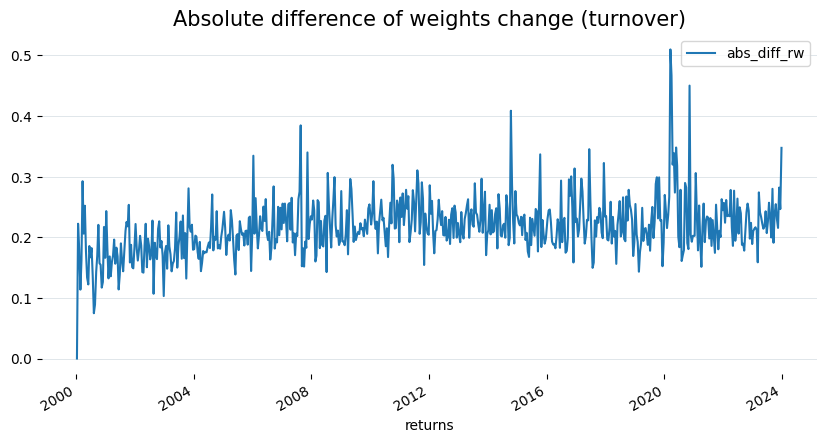

In [22]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

df_glob_alloc.pivot(index="date", on="name", values="rw_glob_model").with_columns(
    pl.sum_horizontal(pl.all().exclude("date").diff().abs().fill_null(0)).alias("abs_diff_rw")
).select(["date", "abs_diff_rw"]).to_pandas().set_index("date").plot(ax=ax)
ax.set_title("Absolute difference of weights change (turnover)", size=15)
ax.set_xlabel("returns")
set_layout(ax=ax)

The total weight change at each bi-monthly rebalancing period is relatively modest, averaging around 0.25. While some portfolios may experience higher turnover (exceeding 1), our allocation strategy demonstrates robustness and adaptability to changing market conditions.

<Axes: title={'center': 'Maximum absolute difference of weights change for one portfolio (turnover)'}, xlabel='returns'>

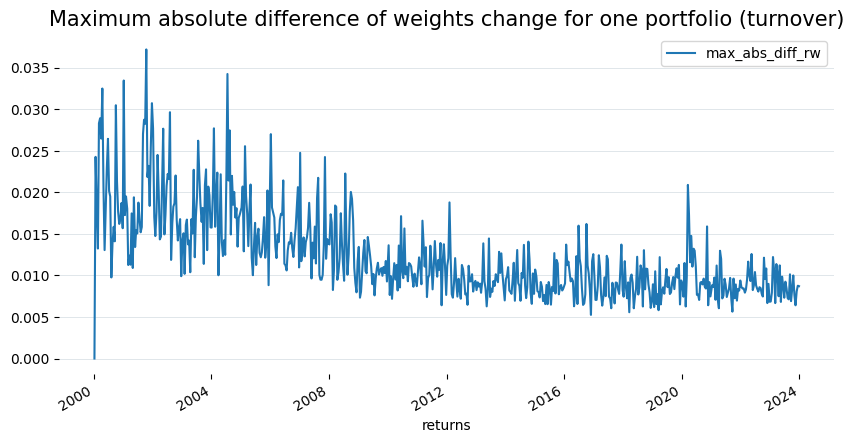

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

df_glob_alloc.pivot(index="date", on="name", values="rw_glob_model").with_columns(
    pl.max_horizontal(pl.all().exclude("date").diff().abs().fill_null(0)).alias("max_abs_diff_rw")
).select(["date", "max_abs_diff_rw"]).to_pandas().set_index("date").plot(ax=ax)
ax.set_title("Maximum absolute difference of weights change for one portfolio (turnover)", size=15)
ax.set_xlabel("returns")
set_layout(ax=ax)

To mitigate liquidity risks, we analyzed the maximum weight change for any single contract per rebalancing period. Excessive weight changes can strain market liquidity. Our allocation strategy demonstrates a relatively low maximum weight change, averaging around 0.015, indicating a manageable rebalancing process.

## Conclusion

This study focused on factor-based portfolios, aiming to enhance the performance of an equally weighted basket by implementing a dynamic allocation strategy using Hierarchical Risk Parity (HRP).

As demonstrated in previous notebooks, risk-adjusted diversification through HRP has significantly improved portfolio metrics, with an average gain of 2% per year while reducing drawdowns and time under water.

While this study was limited to US factor-based portfolios, future research could extend the HRP approach to factor portfolios from other regions like Europe and Asia. This would not only leverage geographical diversification but also potentially further enhance performance metrics.

Another promising direction is to develop a model-based Reinforcement Learning agent capable of dynamically allocating weights across various allocation models (e.g., HRP [3, 6, 12, 24], HARP [3, 6, 12, 24]). This agent could adapt to changing market conditions, potentially optimizing portfolio performance.

This work is currently in progress.